# Metropolis sampling

In this notebook we analyse the results from VMC calculations on a spherical harmonic oscillator using brute force Metropolis.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tqdm

from vmc.interface import PyHarmonicOscillator, PyMetropolisAlgorithm, \
    PySimpleGaussian, PySimpleGaussianNumerical, PySampler, \
    PyImportanceMetropolis

from IPython.core.pylabtools import figsize

In [2]:
sns.set(color_codes=True)
figsize(14, 10)

We use natural units with $m = \hbar = c = 1$. We also restrict our views to $\omega = 1$ in this analysis.

In [3]:
mass = 1.0
omega = 1.0
hbar = 1.0

In [4]:
spread = 1.0
step_length = 0.1

## The one dimensional spherical harmonic oscillator

Starting with the simplest case we look at the one dimensional spherical harmonic oscillator.

\begin{align}
    \Psi_T(\mathbf{x}) &= \prod_{i = 1}^N\exp(-\alpha x_i).
\end{align}

We wish to compare the CPU time of the analytical scheme, i.e., an analytical expression for the Laplcian and hence the local energy, versus a central difference scheme of second order.

We know that the exact ground state energy for the one dimensional spherical harmonic oscillator can be found at $\alpha = 0.5$. By restricting our view to the region $\alpha \in [0.1, 0.7]$ we should observe a trend where the average energy goes towards a minimum at $\alpha = 0.5$ and increases on both sides.

In [5]:
alpha_min = 0.4
alpha_max = 0.6
num_alphas = 5

alphas = np.linspace(alpha_min, alpha_max, num_alphas).reshape(num_alphas, 1)

In [6]:
num_particles = 300
num_dimensions = 1
num_parameters = 1

num_samples = int(num_particles * 12000)
num_thermalization_steps = int(num_particles * 2000)

In [7]:
num_local_energies = 0

In [8]:
solver = PyMetropolisAlgorithm(num_particles)
#solver = PyImportanceMetropolis(num_particles)
wavefunction_analytical = PySimpleGaussian(
    num_particles, num_dimensions, num_parameters, mass, omega, spread=spread)
#wavefunction_approximate = PySimpleGaussianNumerical(
#    num_particles, num_dimensions, num_parameters, mass, omega, spread=spread)
hamiltonian = PyHarmonicOscillator()

In [9]:
sampler = PySampler(
    wavefunction_analytical, hamiltonian, solver, num_local_energies)

In [10]:
energies_analytical = np.zeros(num_alphas)
variance_analytical = np.zeros(num_alphas)
#energies_approximate = np.zeros(num_alphas)
#variance_approximate = np.zeros(num_alphas)
num_experiments = 1

for experiment in tqdm.tqdm(range(num_experiments)):
    for i in range(num_alphas):
        wavefunction_analytical.set_parameters(alphas[i])
        #wavefunction_approximate.set_parameters(alphas[i])

        sampler.sample(num_samples, step_length, num_thermalization_steps=num_thermalization_steps)

        energies_analytical[i] += sampler.get_energy()
        variance_analytical[i] += sampler.get_variance()
        wavefunction_analytical.redistribute()
        #wavefunction_approximate.redistribute()

energies_analytical /= num_experiments
variance_analytical /= num_experiments
#energies_approximate /= num_samples

100%|██████████| 1/1 [00:14<00:00, 14.66s/it]


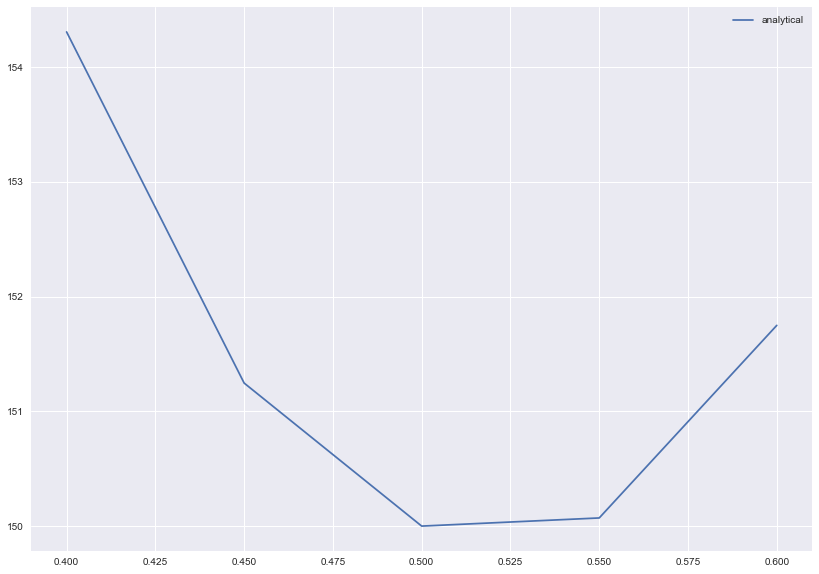

In [11]:
plt.plot(alphas.ravel(), energies_analytical, label="analytical")
#plt.plot(alphas.ravel(), energies_approximate, label="approximate")
plt.legend(loc="best")
plt.show()

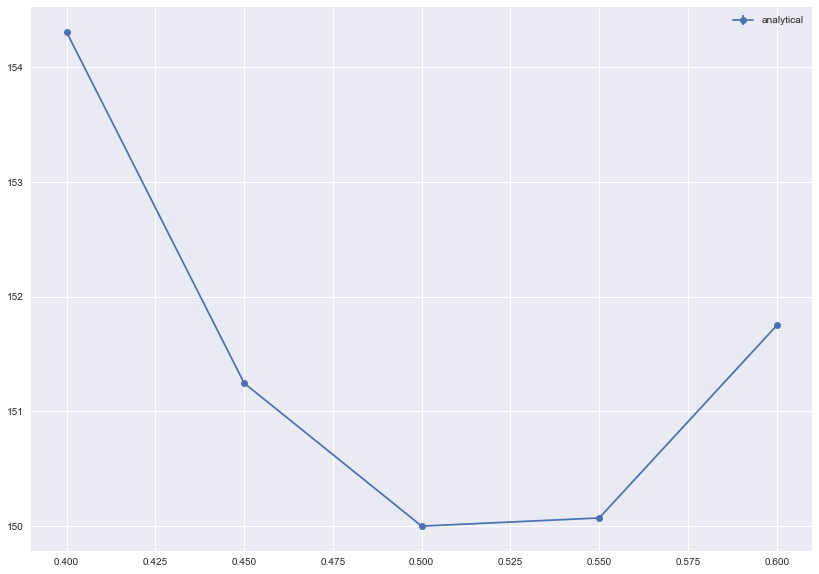

In [12]:
plt.errorbar(
    alphas.ravel(), energies_analytical, yerr=np.sqrt(variance_analytical)/np.sqrt(num_samples),
    label="analytical", fmt="o-")
#plt.errorbar(
#    alphas.ravel(), energies_approximate, yerr=np.sqrt(variance_approximate),
#    label="approximate")
plt.legend(loc="best")
plt.show()

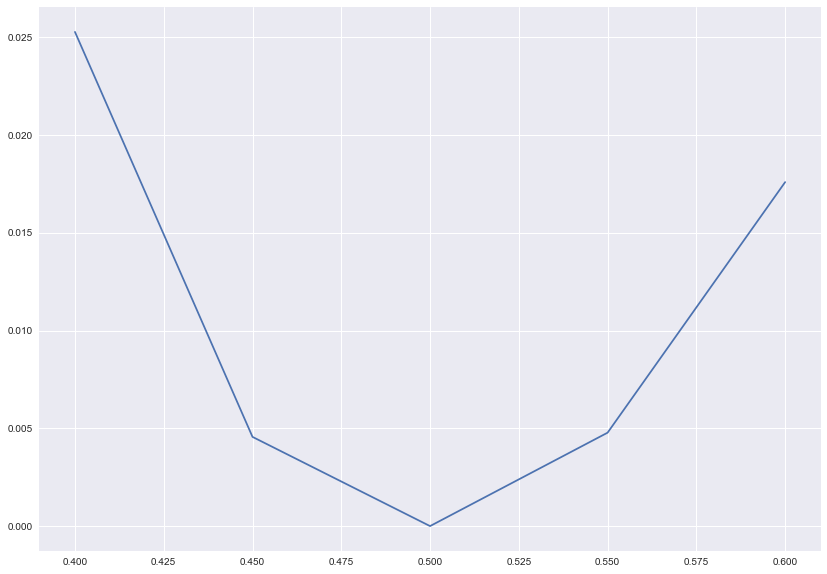

In [13]:
plt.plot(alphas.ravel(), variance_analytical/num_particles)
plt.show()

In [14]:
for alpha, energy, variance in zip(alphas, energies_analytical, variance_analytical):
    print ("Alpha: {0:8.8f} Energy: {1:8.8f} Variance: {2:8.8f}".format(
        alpha[0], energy/num_particles, variance/num_particles))

Alpha: 0.40000000 Energy: 0.51436057 Variance: 0.02527964
Alpha: 0.45000000 Energy: 0.50415659 Variance: 0.00456352
Alpha: 0.50000000 Energy: 0.50000000 Variance: 0.00000000
Alpha: 0.55000000 Energy: 0.50023647 Variance: 0.00477876
Alpha: 0.60000000 Energy: 0.50583237 Variance: 0.01759583


In [15]:
print (sampler.get_ratio_of_accepted_steps())

0.9696222222222223


In [16]:
def exact_energy(alpha, omega, mass, num_particles, num_dimensions):
    first_term = hbar**2*num_dimensions*alpha*num_particles/float(mass)
    second_term = 0.5*mass*omega**2*num_particles*(1.0/(4.0*alpha))*num_dimensions
    third_term = -2*hbar**2*alpha**2*num_particles/float(mass)*(1.0/(4.0*alpha))*num_dimensions

    return first_term + second_term + third_term

In [17]:
energy_exact = np.zeros(num_alphas)

for i in range(num_alphas):
    energy_exact[i] = exact_energy(alphas[i, 0], omega, mass, num_particles, num_dimensions)

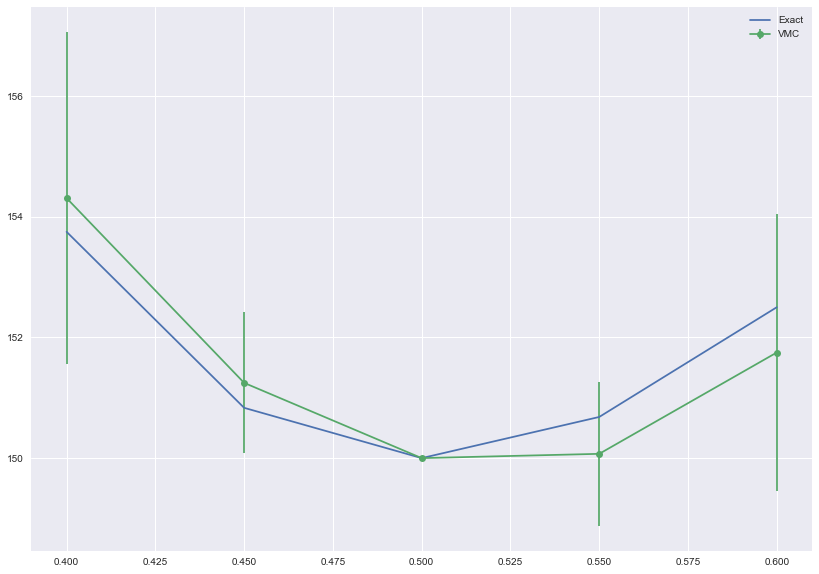

In [18]:
plt.plot(alphas.ravel(), energy_exact, label="Exact")
plt.errorbar(
    alphas.ravel(), energies_analytical, yerr=np.sqrt(variance_analytical),
    label="VMC", fmt="o-")
plt.legend(loc="best")
plt.show()